<a href="https://colab.research.google.com/github/bipinKrishnan/fastai_course/blob/master/image_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade

In [2]:
import torch
import fastai as fastai
import fastai.vision.all as vision

from PIL import Image 
import numpy as np

In [ ]:
path = vision.untar_data(vision.URLs.BIWI_HEAD_POSE)
path.ls()

In [ ]:
path.ls()[0].ls().sorted(), path.ls()[2].ls().sorted()

get_image_files walks through all the directories and reads only images(like with extension .jpg, .jpeg etc)

In [8]:
img_files = vision.get_image_files(path).sorted()

In [ ]:
str(img_files[0])[:-7], f'{str(img_files[0])[:-7]}pose.txt'

In [ ]:
def img2pose(img_file): return f'{str(img_file)[:-7]}pose.txt'

img2pose(img_files[8])

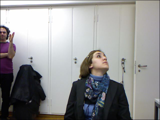

In [ ]:
im = Image.open(img_files[2000])
im.to_thumb(h=160)

skip_header --> No. of lines to skip at the begining of the file

skip_footer --> No. of lines to skip at the end of the file

In [ ]:
np.genfromtxt(img2pose(img_files[0])), np.genfromtxt(img2pose(img_files[0]), skip_header=3)

In [6]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

#function to get the coordinates of centre point of face
def get_ctr(img_file):
  ctr = np.genfromtxt(img2pose(img_file), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return torch.tensor([c1,c2])

In [ ]:
get_ctr(img_files[9])

tensor([350.7417, 262.8703], dtype=torch.float64)

Splitting based on the parent name of the folder, the folder name is just numbers like --01, 02, 03 .....

So if the condition parent folder name == 13 evaluates to True, then it is a validation set, else it is given to the training set.



In [55]:
db = vision.DataBlock(
    blocks=(vision.ImageBlock, vision.PointBlock),
    get_items=vision.get_image_files,
    get_y=get_ctr,
    splitter=vision.FuncSplitter(lambda x: x.parent.name == '13'),
    batch_tfms=[*vision.aug_transforms(size=(240, 320)),
                vision.Normalize.from_stats(*vision.imagenet_stats)]
)

In [ ]:
db.datasets(path)

In [ ]:
db.summary(path)

In [ ]:
dls = db.dataloaders(path, bs=32)

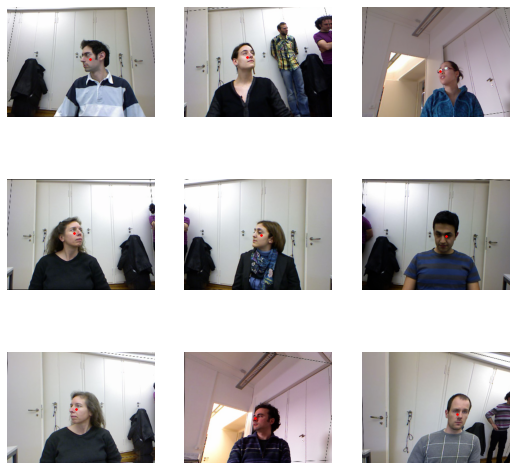

In [ ]:
dls.show_batch()

In [ ]:
x, y = dls.one_batch()
x.shape, y.shape, y[3]

If y_range is set, then the final layer of the model is sigmoid(x)*(hi-lo) + lo

hi -- higher range

lo -- lower range

This is implemented in fastai using a function:

def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [ ]:
learn = vision.cnn_learner(dls, vision.resnet18, y_range=(-1, 1))

In [ ]:
learn.model

## SigmoidRange simple implementation

In [ ]:
class SigmoidRange(torch.nn.Module):
  def __init__(self, lo, hi):
    super().__init__()
    self.lo = lo
    self.hi = hi

  def __call__(self, x):
    return torch.sigmoid(x) * (self.hi-self.lo) + self.lo

In [ ]:
x = torch.nn.Sequential(
    torch.nn.Linear(3, 2),
    SigmoidRange(-1, 1)
)

x1 = torch.nn.Sequential(
    torch.nn.Linear(3, 2),
    SigmoidRange(-1, 10)
)

print(x, x1)

In [ ]:
t = torch.randn(10, 3)

x(t), x1(t)

Acts just like an activation function by limiting the value to be between the ranges

## Back to work

In [ ]:
learn.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.511886486900039e-05)

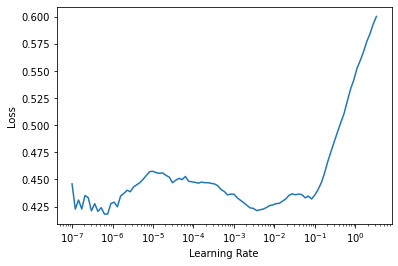

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(3, 1e-2)

epoch,train_loss,valid_loss,time
0,0.043027,0.004135,01:58


epoch,train_loss,valid_loss,time
0,0.006489,0.000754,02:03
1,0.002875,0.000248,02:04
2,0.002014,0.000183,02:04


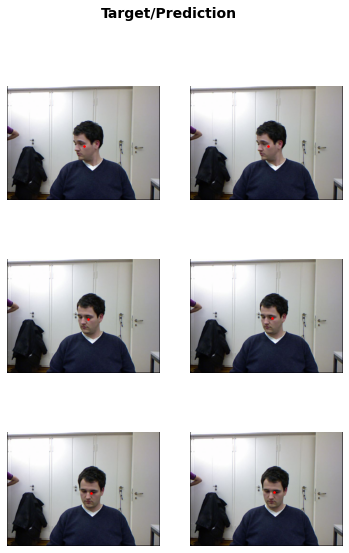

In [ ]:
learn.show_results()

In [ ]:
pred, targ = learn.get_preds()

In [ ]:
pred[0], targ[0]

(tensor([ 0.0832, -0.0574]), tensor([[ 0.0706, -0.0489]]))